In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io

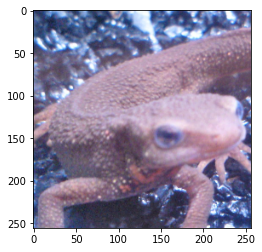

In [8]:
img_base_url = "https://github.com/yoyoyo-yo/Gasyori100knock/blob/master/"
img_orig = io.imread(img_base_url + "dataset/images/imori_256x256.png?raw=true")
plt.imshow(img_orig)

## Question 58 ラベリング 4近傍

![](https://github.com/yoyoyo-yo/Gasyori100knock/blob/master/dataset/images/seg_sample.png?raw=true)

seg.pngをラベリングせよ。

ラベリングとは隣接したピクセルに同じラベルを割り当てる作業である。

つまり、

* 黒　黒　黒　黒
* 黒　白　白　黒
* 黒　白　黒　黒
* 黒　黒　黒　黒

このように隣り合った白ピクセルは同じラベルを割り当てる。


> 二値化画像処理された画像において、白の部分（または黒の部分）が連続した画素に同じ番号を割り振る処理を
ラベリングと言います。
>
> 通常、同じ番号ごとの面積（画素数）や幅、高さなどの特徴量を求めて欠陥検査や分類処理などに用いられます。
> 
> ラベリングには、二値化された画像の縦、横方向に連続している部分を同じラベルにする４連結と、
> 縦、横、斜め方向に連続している部分を同じラベルにする８連結との２種類の処理があります。（４近傍、８近傍という場合もあります。）

[https://imagingsolution.net/imaging/labelling/](https://imagingsolution.net/imaging/labelling/)

このようにピクセルの塊にラベリングしたものはConnected Componentとも呼ばれる。

ここでは４近傍に注目してラベリングを行う。 また、ここではルックアップテーブルというものを使用する。

ルックアップテーブルとは

|Source|Distination|
|---|---|
|1|1|
|2|2|
|3|1|

というような表になっており、Source=1に割り当てた画素には最終的にラベル1を割り当てる、Source =3に割り当てた画素には最終的にラベル1を割り当てることを示す表である。

アルゴリズムは

左上からラスタスキャンを行う。 注目画素i(x,y)が黒画素なら何も行わない。白画素なら、上画素i(x,y-1)と左画素i(x-1,y)に注目し、どちらも0だった場合、最後に割り当てたラベル+1を割り当てる。 どちらか一方以上が0でない場合（つまりすでにラベルが割り合っている場合）、上と左に割り当てられたラベルの中で最小の方(0以外)をi(x,y)に割り当てる。ここで、上か左で用いなかったラベルに対応するルックアップテーブルをここで割り当てた番号に変える。 最後、ルックアップテーブルを見て、Sourceに対応する画素に当たる部分をDistinationの値に変換する。 以上により隣接ピクセル同士に同じラベルを割り当てる。 4近傍としているが、ラスタスキャンのため、上画素と左画素の２画素に注目すればいい。

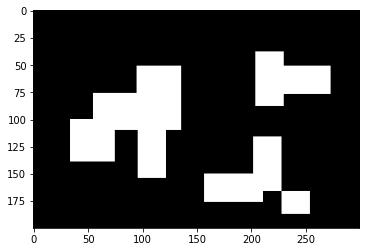

In [11]:
seg = io.imread(img_base_url + "dataset/images/seg_sample.png?raw=true")
plt.imshow(seg, cmap='gray')

In [18]:
seg.shape

(200, 300)

In [16]:
h, w = seg.shape
label = np.zeros((h, w), dtype=int)
label[seg > 0] = 1

In [299]:
def labeling_4nn(img):
    h, w = img.shape

    label = np.zeros((h, w), dtype=int)
    label[img > 0] = 1

    # look up table
    LUT = [0 for _ in range(h * w)]
#     LUT = [i for i in range(h * w)]

    n = 1

    for y in range(h):
        for x in range(w):
            # skip black pixel
            if label[y, x] == 0:
                continue
            
            # get above pixel
            c3 = label[max(y-1,0), x]

            # get left pixel
            c5 = label[y, max(x-1,0)]

            # if not labeled
            if c3 < 2 and c5 < 2:
                # labeling
                n += 1
                label[y, x] = n
            else:
                # replace min label index
                _vs = [c3, c5]
                vs = [a for a in _vs if a > 1]
                v = min(vs)
                label[y, x] = v
                
                minv = v
                for _v in vs:
                    if LUT[_v] != 0:
                        minv = min(minv, LUT[_v])
                for _v in vs:
                    LUT[_v] = minv
    
    
#     print(label)
    
    count = 1

    # integrate index of look up table
    for l in range(2, n+1):
        flag = True
        for i in range(n+1):
            if LUT[i] == l:
                if flag:
                    count += 1
                    flag = False
                LUT[i] = count

    # draw color
    COLORS = [[0, 0, 255], [0, 255, 0], [255, 0, 0], [255, 255, 0]]
    out = np.zeros((h, w, 3), dtype=np.uint8)
    
#     print(label)
#     print(LUT)

    for i, lut in enumerate(LUT[2:]):
        out[label == (i+2)] = COLORS[lut % len(COLORS)]

    return out

In [344]:
# うまくいってない

def labeling_4nn_re(img):
    h, w = img.shape
    
    label = np.zeros((h, w), dtype=int)
    
    # look up table
    LUT = [i for i in range(h * w)]
    
    n = 0
    
    for y in range(h):
        for x in range(w):
            # skip black pixel
            if img[y, x] == 0:
                continue
            
            # check pixel above
            above = label[max(y-1, 0), x]
            
            # check pixel left
            left = label[y, max(x-1, 0)]
            
            # if both are not labeled, add new label
            if above < 1 and left < 1:
                n += 1
                label[y, x] = n
            else:
                # if either or both of them are labeled, take the smallest labeled number
                _vs = [above, left]
                vs = [a for a in _vs if a > 0]
                v_min = min(vs)
                label[y, x] = v_min
                
                # update the look up table (link unused labels to used label)
                for _v in vs:
                    if LUT[_v] > 0:
                        v_min = min(v_min, LUT[_v])
                for _v in vs:
                    LUT[_v] = v_min
    
#     print(label)
#     print(LUT)
    
    # adjust LUT    
    count = 0
    LUT = LUT[:n+1]
    for i in range(1, n+1):
        flag = True
        for j in range(n+1):
            if LUT[j] == i:
                if flag:
                    count += 1
                    flag = False
                LUT[j] = count
        
#     print(LUT)
    
    # update label based on LUT
    for y in range(h):
        for x in range(w):
            label[y, x] = LUT[label[y, x]]
    
#     print(label)
    
    # draw color
    COLORS = [[0, 0, 255], [0, 255, 0], [255, 0, 0], [255, 255, 0]]
    out = np.zeros((h, w, 3), dtype=np.uint8)
    
    for i in range(n):
#         print(i + 1, i % len(COLORS))
        out[label == i + 1] = COLORS[i % len(COLORS)]
                
    return out

In [250]:
seg_1 = np.array([[0, 0, 0, 1, 1, 1, 1, 0, 0],
                  [0, 0, 0, 1, 1, 0, 1, 0, 0],
                  [0, 1, 1, 0, 0, 0, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 0, 0, 0, 0, 0, 1, 0]])

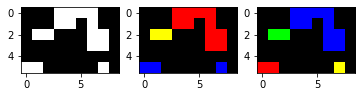

In [305]:
plt.subplot(1, 3, 1)
plt.imshow(seg_1, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(labeling_4nn(seg_1))
plt.subplot(1, 3, 3)
plt.imshow(labeling_4nn_re(seg_1))

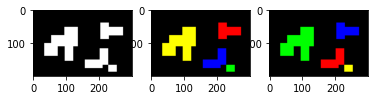

In [303]:
plt.subplot(1, 3, 1)
plt.imshow(seg, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(labeling_4nn(seg))
plt.subplot(1, 3, 3)
plt.imshow(labeling_4nn_re(seg))

In [235]:
seg_2 = io.imread("https://imagingsolution.net/wordpress/wp-content/uploads/2011/03/252d685220a9f45b2384a6f64b822ec6.png")

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


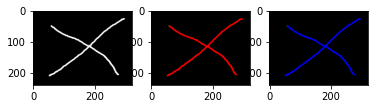

In [343]:
plt.subplot(1, 3, 1)
plt.imshow(seg_2, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(labeling_4nn(seg_2))
plt.subplot(1, 3, 3)
plt.imshow(labeling_4nn_re(seg_2))

In [237]:
seg_3 = io.imread("https://imagingsolution.net/wordpress/wp-content/uploads/2011/03/e5b8c6f1a38a4dc210a9a1ec6fa2f21a.png")

[0, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 4, 4, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1]


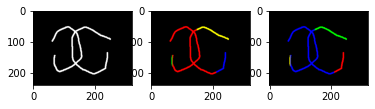

In [342]:
plt.subplot(1, 3, 1)
plt.imshow(seg_3, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(labeling_4nn(seg_3))
plt.subplot(1, 3, 3)
plt.imshow(labeling_4nn_re(seg_3))

In [285]:
seg_4 = io.imread("https://imagingsolution.net/wordpress/wp-content/uploads/2011/03/4e9ace1bc0ab589a54b4c225e2e95c58.png")

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 2, 3, 1, 2, 1, 3, 1, 2, 1, 1, 2, 1, 3, 2, 1, 3, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 4, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 5, 1]


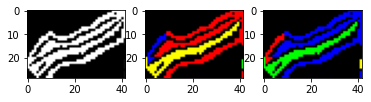

In [341]:
plt.subplot(1, 3, 1)
plt.imshow(seg_4, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(labeling_4nn(seg_4))
plt.subplot(1, 3, 3)
plt.imshow(labeling_4nn_re(seg_4))

## Question 59 ラベリング 8近傍

ここではQ.58のラベリングを8近傍に変えてラベリングを行え。

8近傍とは、i(x-1,y-1), i(x, y-1), i(x+1,y-1), i(x-1,y)の4画素に注目すればよい。

In [306]:
def labeling_8nn(img):
    # get image shape
    h, w = img.shape

    # prepare labeling image
    label = np.zeros((h, w), dtype=int)
    label[img > 0] = 1

    # look up table
    LUT = [0 for _ in range(h * w)]

    n = 1

    for y in range(h):
        for x in range(w):
            if label[y, x] == 0:
                continue
            # get right top pixel
            c2 = label[max(y-1,0), min(x+1, w-1)]
            # get top pixel
            c3 = label[max(y-1,0), x]
            # get left top pixel
            c4 = label[max(y-1,0), max(x-1,0)]
            # get left pixel
            c5 = label[y, max(x-1,0)]

            # if all pixel is non labeled
            if c3 < 2 and c5 < 2 and c2 < 2 and c4 < 2:
                n += 1
                label[y, x] = n
            else:
                # get labeled index
                _vs = [c3, c5, c2, c4]
                vs = [a for a in _vs if a > 1]
                v = min(vs)
                label[y, x] = v

                minv = v
                for _v in vs:
                    if LUT[_v] != 0:
                        minv = min(minv, LUT[_v])
                for _v in vs:
                    LUT[_v] = minv
                    
    count = 1

    # integrate labeled index of look up table
    for l in range(2, n+1):
        flag = True
        for i in range(n+1):
            if LUT[i] == l:
                if flag:
                    count += 1
                    flag = False
                LUT[i] = count

    # draw color
    COLORS = [[0, 0, 255], [0, 255, 0], [255, 0, 0], [255, 255, 0]]
    out = np.zeros((h, w, 3), dtype=np.uint8)

    for i, lut in enumerate(LUT[2:]):
        out[label == (i+2)] = COLORS[lut-2]

    return out

In [353]:
# うまくいってない

def labeling_8nn_re(img):
    h, w = img.shape
    
    label = np.zeros((h, w), dtype=int)
    
    # look up table
    LUT = [i for i in range(h * w)]
    
    n = 0
    
    for y in range(h):
        for x in range(w):
            # skip black pixel
            if img[y, x] == 0:
                continue
            
            # check pixel above
            above = label[max(y-1, 0), x]
            
            # check pixel left
            left = label[y, max(x-1, 0)]
            
            # check pixel left above
            leftabove = label[max(y-1, 0), max(x-1, 0)]
            
            # check pixel right above
            rightabove = label[max(y-1, 0), min(x+1, w-1)]
            
            # if both are not labeled, add new label
            if above < 1 and left < 1 and leftabove < 1 and rightabove < 1:
                n += 1
                label[y, x] = n
            else:
                # if either or both of them are labeled, take the smallest labeled number
                _vs = [above, left, leftabove, rightabove]
                vs = [a for a in _vs if a > 0]
                v_min = min(vs)
                label[y, x] = v_min
                
                # update the look up table (link unused labels to used label)
                for _v in vs:
                    if LUT[_v] > 0:
                        v_min = min(v_min, LUT[_v])
                for _v in vs:
                    LUT[_v] = v_min
    
#     print(label)
#     print(LUT)
    
    # adjust LUT    
    count = 0
    LUT = LUT[:n+1]
    for i in range(1, n+1):
        flag = True
        for j in range(n+1):
            if LUT[j] == i:
                if flag:
                    count += 1
                    flag = False
                LUT[j] = count
        
#     print(LUT)
    
    # update label based on LUT
    for y in range(h):
        for x in range(w):
            label[y, x] = LUT[label[y, x]]
    
#     print(label)
    
    # draw color
    COLORS = [[0, 0, 255], [0, 255, 0], [255, 0, 0], [255, 255, 0]]
    out = np.zeros((h, w, 3), dtype=np.uint8)
    
    for i in range(n):
#         print(i + 1, i % len(COLORS))
        out[label == i + 1] = COLORS[i % len(COLORS)]
                
    return out

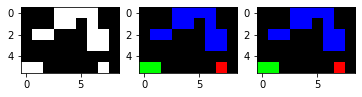

In [346]:
plt.subplot(1, 3, 1)
plt.imshow(seg_1, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(labeling_8nn(seg_1))
plt.subplot(1, 3, 3)
plt.imshow(labeling_8nn_re(seg_1))

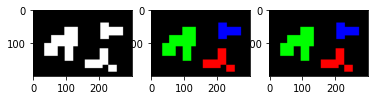

In [347]:
plt.subplot(1, 3, 1)
plt.imshow(seg, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(labeling_8nn(seg))
plt.subplot(1, 3, 3)
plt.imshow(labeling_8nn_re(seg))

In [329]:
np.set_printoptions(threshold=np.inf)

In [235]:
seg_2 = io.imread("https://imagingsolution.net/wordpress/wp-content/uploads/2011/03/252d685220a9f45b2384a6f64b822ec6.png")

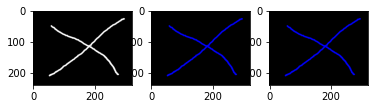

In [348]:
plt.subplot(1, 3, 1)
plt.imshow(seg_2, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(labeling_8nn(seg_2))
plt.subplot(1, 3, 3)
plt.imshow(labeling_8nn_re(seg_2))

In [237]:
seg_3 = io.imread("https://imagingsolution.net/wordpress/wp-content/uploads/2011/03/e5b8c6f1a38a4dc210a9a1ec6fa2f21a.png")

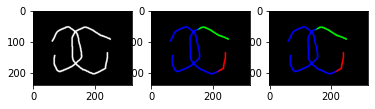

In [349]:
plt.subplot(1, 3, 1)
plt.imshow(seg_3, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(labeling_8nn(seg_3))
plt.subplot(1, 3, 3)
plt.imshow(labeling_8nn_re(seg_3))

In [285]:
seg_4 = io.imread("https://imagingsolution.net/wordpress/wp-content/uploads/2011/03/4e9ace1bc0ab589a54b4c225e2e95c58.png")

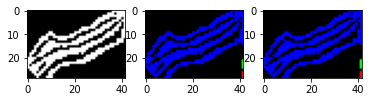

In [352]:
plt.subplot(1, 3, 1)
plt.imshow(seg_4, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(labeling_8nn(seg_4))
plt.subplot(1, 3, 3)
plt.imshow(labeling_8nn_re(seg_4))